In [ ]:
# !pip install wandb

In [ ]:
# import wandb
# !wandb login

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from scipy.stats import qmc, norm
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid', font_scale=1.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def black_scholes(S, K, T, r, sigma, option='call'):
    """
    Black-Scholes closed-form formula for European call and put options.
    
    Parameters:
        S (float): underlying asset price
        K (float): option strike price
        T (float): time to maturity in years
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset
        option (str): 'call' for call option, 'put' for put option (default is 'call')
    
    Returns:
        float: option price according to the Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

In [ ]:
example_param_set = {
    'S' : 0.5,
    'K' : 1,
    'T' : 0.5,
    'r' : 0.05,
    'sigma' : 0.3 
}

black_scholes(**example_param_set)

3.2874437202908e-05

## Parameters sampling

In [ ]:
# S2K, T, r, sigma -> V2K
# r may be constant
n_samples = 100_000
l_bounds = [0.3, 0.05, 0.02, 0.01]
r_bounds = [4, 1, 0.1, 1]
lhc = qmc.LatinHypercube(d=4)
bs_params = qmc.scale(lhc.random(n=n_samples), l_bounds, r_bounds)
bs_params.shape

(100000, 4)

In [ ]:
real_df.describe()

,S2K,T,r,sigma,V2K,log_V2K
count,97.000000,97.000000,9.700000e+01,97.000000,97.000000,97.000000
mean,1.293354,0.007812,5.000000e-02,2.167884,0.375753,-4.759115
std,0.685203,0.000000,6.974940e-18,2.812495,0.640623,4.377930
min,0.588780,0.007812,5.000000e-02,0.246101,0.000020,-10.819778
25%,0.841114,0.007812,5.000000e-02,0.562504,0.000063,-9.672501
50%,1.060865,0.007812,5.000000e-02,1.204106,0.052844,-2.940410
75%,1.471950,0.007812,5.000000e-02,2.433598,0.426316,-0.852575
max,3.679875,0.007812,5.000000e-02,14.885255,2.614375,0.961025


In [ ]:
df.describe()

,S2K,T,r,sigma,V2K,log_V2K
count,93611.000000,93611.000000,93611.000000,93611.000000,9.361100e+04,93611.000000
mean,1.029018,0.532833,0.060046,0.530639,2.394158e-01,-2.633330
std,0.337438,0.272281,0.023085,0.275819,2.131914e-01,2.696542
min,0.400008,0.050004,0.020000,0.010011,1.001177e-07,-16.116920
25%,0.747757,0.299227,0.040084,0.299606,3.770701e-02,-3.277909
50%,1.038337,0.535589,0.060063,0.535952,1.885338e-01,-1.668478
75%,1.319170,0.768581,0.080043,0.768274,4.142735e-01,-0.881229
max,1.599990,1.000000,0.100000,0.999996,8.641004e-01,-0.146066


In [ ]:
prices = np.apply_along_axis(
    func1d=lambda x: black_scholes(x[0], 1, x[1], x[2], x[3]), 
    axis=1,
    arr=bs_params
)
prices.shape

(100000,)

In [ ]:
df = pd.DataFrame(data=bs_params, columns=['S2K', 'T', 'r', 'sigma'])
df['V2K'] = prices
display(df.head())
df.info()

,S2K,T,r,sigma,V2K
0,0.862684,0.250562,0.052883,0.612855,0.061212
1,1.086517,0.072702,0.031788,0.200843,0.090215
2,0.655598,0.203623,0.084469,0.520506,0.003232
3,1.242944,0.603800,0.057327,0.630338,0.379126
4,1.003555,0.240331,0.028762,0.671271,0.135764


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   S2K     100000 non-null  float64
 1   T       100000 non-null  float64
 2   r       100000 non-null  float64
 3   sigma   100000 non-null  float64
 4   V2K     100000 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB


In [ ]:
# df['time_value'] = df['V2K'] - np.maximum(0, df['S2K'] - np.exp(-df['r'] * df['T']))
# df = df.loc[df.time_value > 1e-7].copy()
# df['log_time_value'] = np.log(df['time_value'])
df = df.loc[df.V2K > 1e-7].copy()
df['log_V2K'] = np.log(df['V2K'])
df.describe()

,S2K,T,r,sigma,V2K,log_V2K
count,93611.000000,93611.000000,93611.000000,93611.000000,9.361100e+04,93611.000000
mean,1.029018,0.532833,0.060046,0.530639,2.394158e-01,-2.633330
std,0.337438,0.272281,0.023085,0.275819,2.131914e-01,2.696542
min,0.400008,0.050004,0.020000,0.010011,1.001177e-07,-16.116920
25%,0.747757,0.299227,0.040084,0.299606,3.770701e-02,-3.277909
50%,1.038337,0.535589,0.060063,0.535952,1.885338e-01,-1.668478
75%,1.319170,0.768581,0.080043,0.768274,4.142735e-01,-0.881229
max,1.599990,1.000000,0.100000,0.999996,8.641004e-01,-0.146066


In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, columns, target):
        self.df = df
        self.columns = columns
        self.target = target
        self.data_tensor = torch.Tensor(df[columns].values)
        self.target_tensor = torch.Tensor(df[target].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.data_tensor[idx], self.target_tensor[idx])

In [ ]:
class ANN(nn.Module):
    def __init__(self, n_in=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
df_train, df_test = train_test_split(df, train_size=0.8)

In [ ]:
columns = [
    # 'log_time_value',
    'log_V2K',
    'r',
    'T',
    'S2K'
]
target = 'sigma'
dataset_train = MyDataset(df_train, columns, target)
dataset_test = MyDataset(df_test, columns, target)
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=256)
dataloader_test = DataLoader(dataset_test, shuffle=False, batch_size=256)

In [ ]:
model = ANN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
def train(model, optimizer, criterion, dataloader_train, dataloader_test, num_epochs):
    logs = {
        'train_loss' : [],
        'test_loss' : []
    }
    model.train()
    for epoch in tqdm(range(num_epochs), desc='Epoch'):
        running_loss = 0.0
        for X,y in dataloader_train:
            X = X.to(device)
            y = y.to(device).unsqueeze(1)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        logs['train_loss'].append(running_loss/len(dataloader_train))

        running_loss = 0.0
        for X,y in dataloader_test:
            with torch.no_grad():
                X = X.to(device)
                y = y.to(device).unsqueeze(1)
                out = model(X)
                loss = criterion(out, y)
                running_loss += loss.item()
        logs['test_loss'].append(running_loss/len(dataloader_train))

    return logs

In [ ]:
logs = train(model, optimizer, criterion, dataloader_train, dataloader_test, num_epochs=100)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

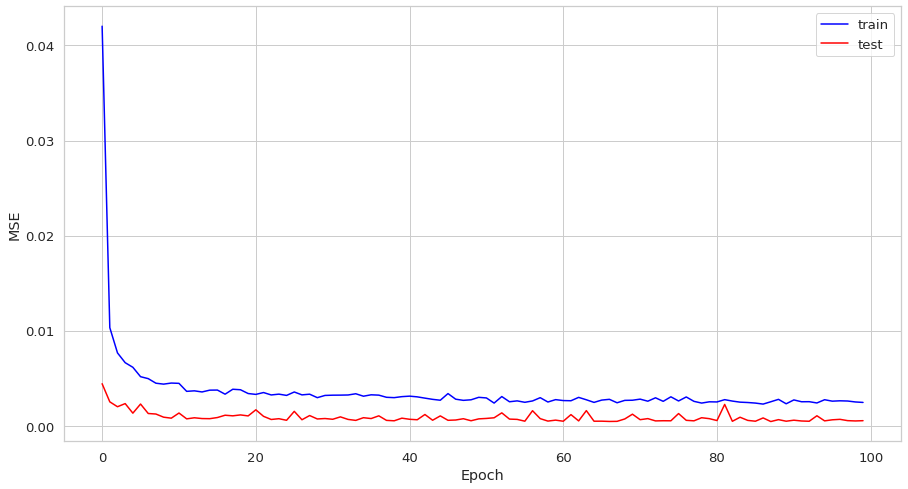

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(logs['train_loss'], c='blue', label='train')
plt.plot(logs['test_loss'], c='red', label='test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Добавим шум в целевую переменную для усложнения задачи

## Тестим на реальных данных MSFT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

data_description = '''
    msft_calls - list of pandas DataFrames, every item corresponds expiration 
                 expiration date from `expirations`. Each DF contains trading
                 info about call option
    
    msft_puts - same but for put options
    
    expirations - tuple of expirations dates in string format `YYYY-MM-DD`
'''

with open("/content/drive/MyDrive/Colab Notebooks/sabr/msft_calls.pickle", 'rb') as msft_file:
  msft_calls = pickle.load(msft_file)
with open("/content/drive/MyDrive/Colab Notebooks/sabr/msft_puts.pickle", 'rb') as msft_file:
  msft_puts = pickle.load(msft_file)
with open("/content/drive/MyDrive/Colab Notebooks/sabr/expirations.pickle", 'rb') as msft_file:
  expirations = pickle.load(msft_file)

msft_stock_price = 294.3900146484375
day = '2022-03-16'

In [ ]:
maturities = [
    (
        datetime.strptime(expiration, '%Y-%m-%d') - 
        (datetime.strptime(day, '%Y-%m-%d') if day else datetime.today())
    ).days / 256 
    for expiration in expirations
]

In [ ]:
msft_calls[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   contractSymbol     97 non-null     object             
 1   lastTradeDate      97 non-null     datetime64[ns, UTC]
 2   strike             97 non-null     float64            
 3   lastPrice          97 non-null     float64            
 4   bid                97 non-null     float64            
 5   ask                97 non-null     float64            
 6   change             97 non-null     float64            
 7   percentChange      97 non-null     float64            
 8   volume             94 non-null     float64            
 9   openInterest       97 non-null     int64              
 10  impliedVolatility  97 non-null     float64            
 11  inTheMoney         97 non-null     bool               
 12  contractSize       97 non-null     object           

In [ ]:
msft_calls[0].head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,MSFT220318C00080000,2022-03-16 18:56:33+00:00,80.0,209.15,212.35,216.35,6.299988,3.105737,41.0,2,8.390630,True,REGULAR,USD
1,MSFT220318C00085000,2022-03-16 19:47:44+00:00,85.0,206.80,207.05,210.80,12.300003,6.323909,1.0,6,7.537110,True,REGULAR,USD
2,MSFT220318C00090000,2022-03-16 13:34:39+00:00,90.0,200.20,202.00,205.90,6.949997,3.596376,1.0,24,7.299806,True,REGULAR,USD
3,MSFT220318C00095000,2022-02-15 20:48:51+00:00,95.0,204.35,197.00,200.00,0.000000,0.000000,6.0,0,6.007815,True,REGULAR,USD
4,MSFT220318C00100000,2022-03-07 18:52:08+00:00,100.0,183.40,192.00,195.35,0.000000,0.000000,1.0,19,6.179690,True,REGULAR,USD


In [ ]:
df.head()

,S/K,T,r,sigma,V/K,time_value,log_time_value
0,0.862684,0.250562,0.052883,0.612855,0.061212,0.061212,-2.793406
1,1.086517,0.072702,0.031788,0.200843,0.090215,0.001390,-6.578765
2,0.655598,0.203623,0.084469,0.520506,0.003232,0.003232,-5.734680
3,1.242944,0.603800,0.057327,0.630338,0.379126,0.102160,-2.281214
4,1.003555,0.240331,0.028762,0.671271,0.135764,0.125320,-2.076886


In [ ]:
dataset_train[0]

(tensor([-4.4484,  0.0605,  0.2391,  1.1681]), tensor(0.3188))

In [ ]:
def real_data_to_format(real_df, real_price, maturity, risk_free_rate):
    df = pd.DataFrame()
    df['S2K'] = real_price / real_df.strike
    df['T'] = maturity
    df['r'] = risk_free_rate
    df['sigma'] = real_df.impliedVolatility
    df['V2K'] = real_df.lastPrice / real_df.strike
    # df['time_value'] = df['V2K'] - np.maximum(0, df['S2K'] - np.exp(-df['r'] * df['T']))
    # df = df.loc[df.time_value > 1e-7].copy()
    # df['log_time_value'] = np.log(df['time_value'])
    # 0/0
    df = df.loc[df.V2K > 1e-7].copy()
    df['log_V2K'] = np.log(df['V2K'])
    return df

In [ ]:
idx = 2
real_df = real_data_to_format(msft_calls[idx], msft_stock_price, maturities[idx], 0.05)
display(real_df.head())
real_df.info()

,S2K,T,r,sigma,V2K,log_V2K
0,1.471950,0.0625,0.05,1.192387,0.427500,-0.849801
1,1.308400,0.0625,0.05,0.745120,0.276889,-1.284139
2,1.252723,0.0625,0.05,0.775393,0.240213,-1.426230
3,1.226625,0.0625,0.05,0.686282,0.211292,-1.554516
4,1.201592,0.0625,0.05,0.642826,0.125714,-2.073744


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S2K      35 non-null     float64
 1   T        35 non-null     float64
 2   r        35 non-null     float64
 3   sigma    35 non-null     float64
 4   V2K      35 non-null     float64
 5   log_V2K  35 non-null     float64
dtypes: float64(6)
memory usage: 1.9 KB


In [ ]:
columns = [
    # 'log_time_value',
    'log_V2K',
    'r',
    'T',
    'S2K'
]
target = 'sigma'
real_dataset = MyDataset(real_df, columns, target)
real_dataloader = DataLoader(real_dataset, shuffle=False, batch_size=len(real_dataset))

In [ ]:
model.eval()
with torch.no_grad():
    X, y = next(iter(real_dataloader))
    X = X.to(device)
    y = y.unsqueeze(1)
    out = model(X).cpu()
    loss = criterion(out, y)
    print(f'Loss: {loss.item():0.4f}')

Loss: 0.1473


In [ ]:
print(f'Train loss: {logs["train_loss"][-1]:0.4f}')
print(f'Test loss: {logs["test_loss"][-1]:0.4f}')

Train loss: 0.0025
Test loss: 0.0005


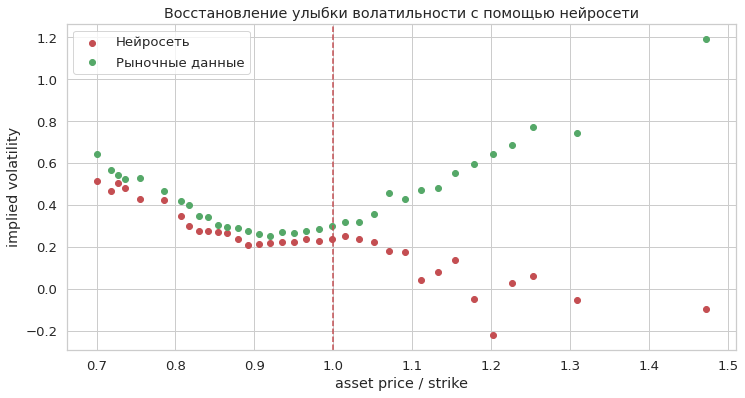

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Восстановление улыбки волатильности с помощью нейросети')
plt.scatter(y=out[:,0], x=real_df.S2K, c='r', label='Нейросеть')
plt.scatter(x=real_df.S2K, y=real_df.sigma, c='g', label='Рыночные данные')
plt.axvline(x=1, c='r', linestyle='--')
plt.xlabel('asset price / strike')
plt.ylabel('implied volatility')
plt.legend()
plt.show()

Надо расширить границы семплинга параметров, чтобы нейросеть могла обучиться более подробно   
Так же стоит добавить шум при обучении, чтобы сетка была более стабильна